# Sales car case - Lighthouse
--- 
### The goal is to use the provided data to make predictions in the 'preco' column, then transmit those predictions to us for analysis.
### With this EDA we will answer the following questions asked by the customer:

- What is the best province registered in the database to sell a popular brand car and why?
- What is the best province to buy a pickup with automatic transmission and why?
- What is the best province to buy cars that are still within the factory warranty and why?




# 1. Importing libraries

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from feature_engine.selection           import DropConstantFeatures, SmartCorrelatedSelection, RecursiveFeatureElimination
from sklearn.metrics                    import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, mean_squared_log_error
from sklearn.model_selection            import KFold, train_test_split
from sklearn.compose                    import ColumnTransformer
from sklearn.pipeline                   import Pipeline
from sklearn.impute                     import SimpleImputer
from sklearn.preprocessing              import StandardScaler,OneHotEncoder,MinMaxScaler,RobustScaler,PolynomialFeatures
from category_encoders.target_encoder   import TargetEncoder
from category_encoders.cat_boost        import CatBoostEncoder
from xgboost                            import XGBRegressor
from catboost                           import CatBoostRegressor
from sklearn.linear_model               import LinearRegression, Lasso, Ridge
from sklearn.neighbors                  import KNeighborsRegressor
from sklearn.ensemble                   import RandomForestRegressor, VotingRegressor, StackingRegressor
from sklearn.tree                       import DecisionTreeRegressor
import shap

# changing some settings
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
#pd.set_option('display.width', 1000)
sns.set_style("darkgrid")

# 2. Importing data

In [41]:
data_train = pd.read_csv("/Users/vitoriawillanidealmeida/Desktop/DATA SCIENCE/Projetos próprios/INDICIUM/cars_train.csv", encoding='utf-16', sep = "\t")
data_test = pd.read_csv("/Users/vitoriawillanidealmeida/Desktop/DATA SCIENCE/Projetos próprios/INDICIUM/cars_test.csv", encoding='utf-16', sep = "\t")

In [42]:
data_train.head()

,id,num_fotos,marca,modelo,versao,ano_de_fabricacao,ano_modelo,hodometro,cambio,num_portas,tipo,blindado,cor,tipo_vendedor,cidade_vendedor,estado_vendedor,anunciante,entrega_delivery,troca,elegivel_revisao,dono_aceita_troca,veiculo_único_dono,revisoes_concessionaria,ipva_pago,veiculo_licenciado,garantia_de_fábrica,revisoes_dentro_agenda,veiculo_alienado,preco
0,300716223898539419613863097469899222392,8.0,NISSAN,KICKS,1.6 16V FLEXSTART SL 4P XTRONIC,2017,2017.0,67772.0,CVT,4,Sedã,N,Branco,PF,Rio de Janeiro,São Paulo (SP),Pessoa Física,False,False,False,NaN,NaN,Todas as revisões feitas pela concessionária,IPVA pago,Licenciado,NaN,NaN,NaN,74732.590084
1,279639842134129588306469566150288644214,8.0,JEEP,COMPASS,2.0 16V FLEX LIMITED AUTOMÁTICO,2017,2017.0,62979.0,Automática,4,Sedã,N,Branco,PF,Belo Horizonte,Minas Gerais (MG),Pessoa Física,False,False,False,Aceita troca,NaN,NaN,IPVA pago,NaN,NaN,NaN,NaN,81965.332634
2,56414460810621048900295678236538171981,16.0,KIA,SORENTO,2.4 16V GASOLINA EX 7L AWD AUTOMÁTICO,2018,2019.0,44070.0,Automática,4,Sedã,N,Preto,PJ,Santos,São Paulo (SP),Loja,True,False,False,Aceita troca,NaN,NaN,NaN,NaN,NaN,NaN,NaN,162824.814472
3,56862509826849933428086372390159405545,14.0,VOLKSWAGEN,AMAROK,2.0 HIGHLINE 4X4 CD 16V TURBO INTERCOOLER DIES...,2013,2015.0,85357.0,Automática,4,Picape,N,Branco,PJ,Sorocaba,São Paulo (SP),Loja,True,True,False,Aceita troca,NaN,NaN,IPVA pago,Licenciado,NaN,NaN,NaN,123681.358857
4,338980975753200343894519909855598027197,8.0,SSANGYONG,KORANDO,2.0 GLS 4X4 16V TURBO DIESEL 4P AUTOMÁTICO,2013,2015.0,71491.0,Automática,4,Utilitário esportivo,N,Preto,PF,Rio de Janeiro,Rio de Janeiro (RJ),Pessoa Física,False,False,False,NaN,NaN,Todas as revisões feitas pela concessionária,NaN,NaN,Garantia de fábrica,Todas as revisões feitas pela agenda do carro,NaN,82419.763891


### Sorting out features and target

In [43]:
features = data_train.drop("preco", axis = 1)
target = data_train["preco"]

In [44]:
features.head()

,id,num_fotos,marca,modelo,versao,ano_de_fabricacao,ano_modelo,hodometro,cambio,num_portas,tipo,blindado,cor,tipo_vendedor,cidade_vendedor,estado_vendedor,anunciante,entrega_delivery,troca,elegivel_revisao,dono_aceita_troca,veiculo_único_dono,revisoes_concessionaria,ipva_pago,veiculo_licenciado,garantia_de_fábrica,revisoes_dentro_agenda,veiculo_alienado
0,300716223898539419613863097469899222392,8.0,NISSAN,KICKS,1.6 16V FLEXSTART SL 4P XTRONIC,2017,2017.0,67772.0,CVT,4,Sedã,N,Branco,PF,Rio de Janeiro,São Paulo (SP),Pessoa Física,False,False,False,NaN,NaN,Todas as revisões feitas pela concessionária,IPVA pago,Licenciado,NaN,NaN,NaN
1,279639842134129588306469566150288644214,8.0,JEEP,COMPASS,2.0 16V FLEX LIMITED AUTOMÁTICO,2017,2017.0,62979.0,Automática,4,Sedã,N,Branco,PF,Belo Horizonte,Minas Gerais (MG),Pessoa Física,False,False,False,Aceita troca,NaN,NaN,IPVA pago,NaN,NaN,NaN,NaN
2,56414460810621048900295678236538171981,16.0,KIA,SORENTO,2.4 16V GASOLINA EX 7L AWD AUTOMÁTICO,2018,2019.0,44070.0,Automática,4,Sedã,N,Preto,PJ,Santos,São Paulo (SP),Loja,True,False,False,Aceita troca,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,56862509826849933428086372390159405545,14.0,VOLKSWAGEN,AMAROK,2.0 HIGHLINE 4X4 CD 16V TURBO INTERCOOLER DIES...,2013,2015.0,85357.0,Automática,4,Picape,N,Branco,PJ,Sorocaba,São Paulo (SP),Loja,True,True,False,Aceita troca,NaN,NaN,IPVA pago,Licenciado,NaN,NaN,NaN
4,338980975753200343894519909855598027197,8.0,SSANGYONG,KORANDO,2.0 GLS 4X4 16V TURBO DIESEL 4P AUTOMÁTICO,2013,2015.0,71491.0,Automática,4,Utilitário esportivo,N,Preto,PF,Rio de Janeiro,Rio de Janeiro (RJ),Pessoa Física,False,False,False,NaN,NaN,Todas as revisões feitas pela concessionária,NaN,NaN,Garantia de fábrica,Todas as revisões feitas pela agenda do carro,NaN


# 3. EDA
---

In [6]:
features.shape

(29584, 28)

### We have 28 features and 1 target variable. Let's see the data types of each feature and the number of missing values.

In [45]:
missing_values = features.isnull().sum()
missing_values

id                             0
num_fotos                    177
marca                          0
modelo                         0
versao                         0
ano_de_fabricacao              0
ano_modelo                     0
hodometro                      0
cambio                         0
num_portas                     0
tipo                           0
blindado                       0
cor                            0
tipo_vendedor                  0
cidade_vendedor                0
estado_vendedor                0
anunciante                     0
entrega_delivery               0
troca                          0
elegivel_revisao               0
dono_aceita_troca           7662
veiculo_único_dono         19161
revisoes_concessionaria    20412
ipva_pago                   9925
veiculo_licenciado         13678
garantia_de_fábrica        25219
revisoes_dentro_agenda     23674
veiculo_alienado           29584
dtype: int64

In [46]:
missing_values_test = data_test.isnull().sum()
missing_values_test

id                            0
num_fotos                    60
marca                         0
modelo                        0
versao                        0
ano_de_fabricacao             0
ano_modelo                    0
hodometro                     0
cambio                        0
num_portas                    0
tipo                          0
blindado                      0
cor                           0
tipo_vendedor                 0
cidade_vendedor               0
estado_vendedor               0
anunciante                    0
entrega_delivery              0
troca                         0
elegivel_revisao              0
dono_aceita_troca          2554
veiculo_único_dono         6387
revisoes_concessionaria    6795
ipva_pago                  3298
veiculo_licenciado         4518
garantia_de_fábrica        8439
revisoes_dentro_agenda     7869
veiculo_alienado           9862
dtype: int64

- `veiculo_alienado` column is all missing, so it does not affect any relevant information and will be removed
- `veiculo_único_dono`, `revisoes_concessionaria`,`ipva_pago`,`veiculo_licenciado`,`garantia_de_fábrica`,`revisoes_dentro_agenda` will be dropped for having too many missing values

In [8]:
features = features.drop(["dono_aceita_troca","veiculo_único_dono","revisoes_concessionaria",
                         "ipva_pago","veiculo_licenciado","garantia_de_fábrica","revisoes_dentro_agenda","veiculo_alienado","num_fotos"], axis=1)

In [47]:
data_test = data_test.drop(["dono_aceita_troca","veiculo_único_dono","revisoes_concessionaria",
                         "ipva_pago","veiculo_licenciado","garantia_de_fábrica","revisoes_dentro_agenda","veiculo_alienado","num_fotos"], axis=1)

In [9]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29584 entries, 0 to 29583
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 29584 non-null  object 
 1   marca              29584 non-null  object 
 2   modelo             29584 non-null  object 
 3   versao             29584 non-null  object 
 4   ano_de_fabricacao  29584 non-null  int64  
 5   ano_modelo         29584 non-null  float64
 6   hodometro          29584 non-null  float64
 7   cambio             29584 non-null  object 
 8   num_portas         29584 non-null  int64  
 9   tipo               29584 non-null  object 
 10  blindado           29584 non-null  object 
 11  cor                29584 non-null  object 
 12  tipo_vendedor      29584 non-null  object 
 13  cidade_vendedor    29584 non-null  object 
 14  estado_vendedor    29584 non-null  object 
 15  anunciante         29584 non-null  object 
 16  entrega_delivery   295

In [10]:
features.columns

Index(['id', 'marca', 'modelo', 'versao', 'ano_de_fabricacao', 'ano_modelo',
       'hodometro', 'cambio', 'num_portas', 'tipo', 'blindado', 'cor',
       'tipo_vendedor', 'cidade_vendedor', 'estado_vendedor', 'anunciante',
       'entrega_delivery', 'troca', 'elegivel_revisao'],
      dtype='object')


### According to our price analysis, a vehicle is considered affordable if its price is below or equivalent to R$80000.

In [11]:
data_train["preco"].describe()

count    2.958400e+04
mean     1.330239e+05
std      8.166287e+04
min      9.869951e+03
25%      7.657177e+04
50%      1.143558e+05
75%      1.636796e+05
max      1.359813e+06
Name: preco, dtype: float64

### We've compiled a list of the most promoted automobile manufacturers below. The five most popular brands in our store are:
1. Chevrolet
2. Volkswagen
3. Hyundai
4. Fiat
5. Honda


In [12]:
por_marca = data_train.loc[data_train["preco"] <= 80000.00, ["preco","marca"]]
count_per_marca = por_marca[["marca"]].value_counts()
count_per_marca


marca        
CHEVROLET        1514
VOLKSWAGEN       1399
HYUNDAI          1087
FIAT              742
HONDA             601
FORD              411
TOYOTA            410
RENAULT           291
MITSUBISHI        221
PEUGEOT           216
JEEP              169
NISSAN            161
AUDI              160
MERCEDES-BENZ     153
CITROËN           142
BMW                90
KIA                77
VOLVO              27
LAND ROVER         25
CHRYSLER           24
TROLLER            23
CHERY              22
DODGE              21
MINI               20
SUZUKI             17
SUBARU             13
SSANGYONG           9
ALFA ROMEO          9
PORSCHE             9
SMART               7
JAGUAR              7
LIFAN               4
MASERATI            3
LEXUS               2
EFFA                1
JAC                 1
BRM                 1
Name: count, dtype: int64

### Below is a breakdown of where you'll find the most billboards for affordable automakers. 

In [13]:
marcas_selecionadas = ["CHEVROLET", "VOLKSWAGEN", "HYUNDAI", "FIAT", "HONDA"]
por_estado = data_train[data_train["marca"].isin(marcas_selecionadas)]
count_per_estado = por_estado["estado_vendedor"].value_counts()
count_per_estado


estado_vendedor
São Paulo (SP)              7480
Rio de Janeiro (RJ)         1157
Paraná (PR)                  987
Santa Catarina (SC)          968
Minas Gerais (MG)            738
Rio Grande do Sul (RS)       672
Goiás (GO)                   340
Bahia (BA)                   272
Pernambuco (PE)              152
Paraíba (PB)                  82
Alagoas (AL)                  77
Rio Grande do Norte (RN)      42
Pará (PA)                     40
Amazonas (AM)                 39
Ceará (CE)                    37
Mato Grosso do Sul (MS)       17
Espírito Santo (ES)           14
Mato Grosso (MT)              11
Tocantins (TO)                10
Acre (AC)                      9
Sergipe (SE)                   5
Piauí (PI)                     4
Maranhão (MA)                  3
Rondônia (RO)                  3
Roraima (RR)                   2
Name: count, dtype: int64

# Answering the first question:
- What is the best province registered in the database to sell a affordable brand car and why?
---

### Answer: Rio Grande do Sul


### Assuming that states with the highest concentrations of ads for popular vehicles are the best bet for selling these vehicles, then the following provinces would be optimal:

1. São Paulo
2. Rio de Janeiro
3. Paraná
4. Santa Catarina
5. Minas Gerais

### This assumption is based on the fact that the high volume of adverts suggests that these automobiles have been purchased in those regions before, suggesting that there is a demand for them there.

### A less obvious strategy would be to avoid the areas with the most commercials and instead focus on those with a decent number of ads (which shows audience approval) because this would protect our ads from being drowned out by the sheer volume of competition. Therefore, we must decide between:

1. Rio Grande do Sul
2. Goiás
3. Bahia
4. Pernambuco
5. Paraíba

### Due to the aforementioned, I propose using a more subtle route and instead promoting well-known automakers in Rio Grande do Sul.

# Answering the second question:


- What is the greatest province to buy an automatic gearbox pickup truck? Why?
---
### Answer: We can see that the best region to acquire a pickup with automatic transmission is São Paulo because it has the greatest supply of these vehicles.

In [14]:
cambio_escolhido = "Automática"
tipo_escolhido = "Picape"

por_estado2 = data_train[(data_train["cambio"] == cambio_escolhido) & (data_train["tipo"] == tipo_escolhido)]
count_per_estado2 = por_estado2["estado_vendedor"].value_counts()
count_per_estado2

estado_vendedor
São Paulo (SP)              1712
Paraná (PR)                  348
Rio de Janeiro (RJ)          318
Santa Catarina (SC)          283
Minas Gerais (MG)            211
Rio Grande do Sul (RS)       198
Goiás (GO)                   102
Bahia (BA)                    68
Pernambuco (PE)               14
Alagoas (AL)                  12
Acre (AC)                      6
Mato Grosso (MT)               6
Mato Grosso do Sul (MS)        5
Sergipe (SE)                   5
Paraíba (PB)                   4
Piauí (PI)                     4
Tocantins (TO)                 3
Rio Grande do Norte (RN)       1
Name: count, dtype: int64

# Answering the third question:
- What is the best region in which to buy cars that are still under factory warranty, and why?
---
### Answer: São Paulo is the best region because it has the most vehicles with this trait specified in our dataset. One note is that the `garantia_de_fábrica` column contains a large number of missing values, implying that this data is not totally accurate.

In [15]:
garantia = "Garantia de fábrica"

por_estado3 = data_train[(data_train["garantia_de_fábrica"] == "Garantia de fábrica")]
count_per_estado3 = por_estado3["estado_vendedor"].value_counts()
count_per_estado3

estado_vendedor
São Paulo (SP)              2307
Rio de Janeiro (RJ)          412
Paraná (PR)                  389
Santa Catarina (SC)          330
Rio Grande do Sul (RS)       281
Minas Gerais (MG)            264
Goiás (GO)                   186
Alagoas (AL)                  58
Bahia (BA)                    51
Pernambuco (PE)               20
Pará (PA)                     17
Mato Grosso do Sul (MS)       13
Rio Grande do Norte (RN)       9
Espírito Santo (ES)            9
Amazonas (AM)                  9
Sergipe (SE)                   3
Mato Grosso (MT)               2
Acre (AC)                      2
Ceará (CE)                     1
Tocantins (TO)                 1
Paraíba (PB)                   1
Name: count, dtype: int64

# 4. After answering the initial question, we move on to more data exploration

In [16]:
features.head()

,id,marca,modelo,versao,ano_de_fabricacao,ano_modelo,hodometro,cambio,num_portas,tipo,blindado,cor,tipo_vendedor,cidade_vendedor,estado_vendedor,anunciante,entrega_delivery,troca,elegivel_revisao
0,300716223898539419613863097469899222392,NISSAN,KICKS,1.6 16V FLEXSTART SL 4P XTRONIC,2017,2017.0,67772.0,CVT,4,Sedã,N,Branco,PF,Rio de Janeiro,São Paulo (SP),Pessoa Física,False,False,False
1,279639842134129588306469566150288644214,JEEP,COMPASS,2.0 16V FLEX LIMITED AUTOMÁTICO,2017,2017.0,62979.0,Automática,4,Sedã,N,Branco,PF,Belo Horizonte,Minas Gerais (MG),Pessoa Física,False,False,False
2,56414460810621048900295678236538171981,KIA,SORENTO,2.4 16V GASOLINA EX 7L AWD AUTOMÁTICO,2018,2019.0,44070.0,Automática,4,Sedã,N,Preto,PJ,Santos,São Paulo (SP),Loja,True,False,False
3,56862509826849933428086372390159405545,VOLKSWAGEN,AMAROK,2.0 HIGHLINE 4X4 CD 16V TURBO INTERCOOLER DIES...,2013,2015.0,85357.0,Automática,4,Picape,N,Branco,PJ,Sorocaba,São Paulo (SP),Loja,True,True,False
4,338980975753200343894519909855598027197,SSANGYONG,KORANDO,2.0 GLS 4X4 16V TURBO DIESEL 4P AUTOMÁTICO,2013,2015.0,71491.0,Automática,4,Utilitário esportivo,N,Preto,PF,Rio de Janeiro,Rio de Janeiro (RJ),Pessoa Física,False,False,False


In [17]:
features.describe()

,ano_de_fabricacao,ano_modelo,hodometro,num_portas
count,29584.000000,29584.000000,29584.000000,29584.000000
mean,2016.758552,2017.808985,58430.592077,3.940677
std,4.062422,2.673930,32561.769309,0.338360
min,1985.000000,1997.000000,100.000000,2.000000
25%,2015.000000,2016.000000,31214.000000,4.000000
50%,2018.000000,2018.000000,57434.000000,4.000000
75%,2019.000000,2020.000000,81953.500000,4.000000
max,2022.000000,2023.000000,390065.000000,4.000000


# These data provided us with the following insights: 
---
- Only 25% of automobiles have been in service for more than 8 years (2023 - 2015 = 8 years), implying that the majority of cars are relatively young. 

- In fact, 25% of cars were constructed after 2019, implying that they have a maximum lifespan of four years.

- The autos covered 58430 km on average.

- The vast majority of advertised vehicles have four doors.

In [18]:
# verifying duplicates
features.loc[features.duplicated(subset=["id"])].head()

,id,marca,modelo,versao,ano_de_fabricacao,ano_modelo,hodometro,cambio,num_portas,tipo,blindado,cor,tipo_vendedor,cidade_vendedor,estado_vendedor,anunciante,entrega_delivery,troca,elegivel_revisao


# Features understanding

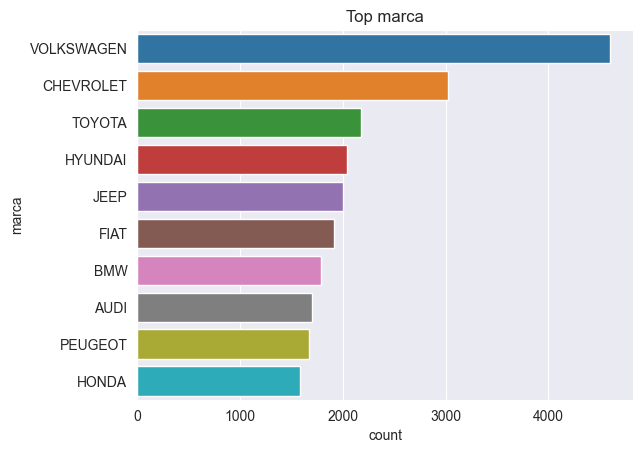

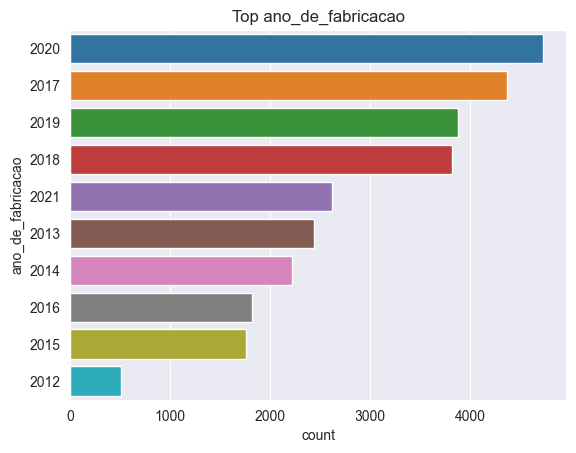

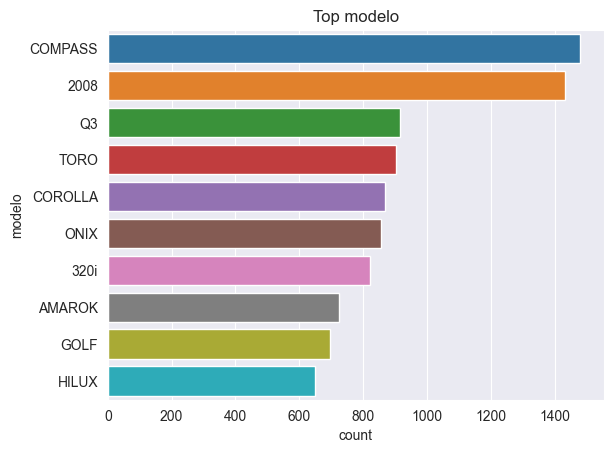

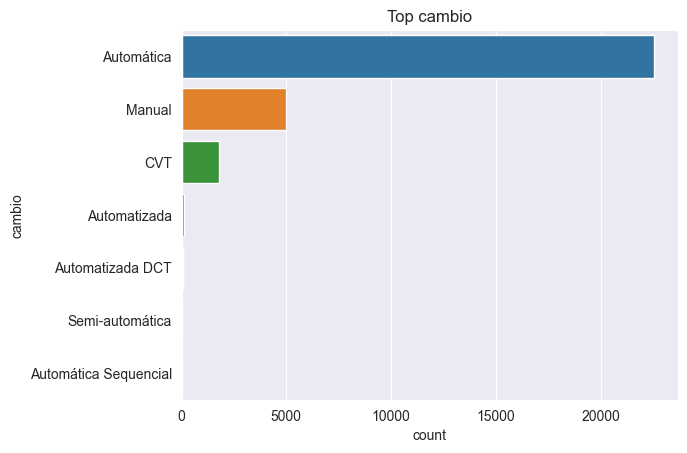

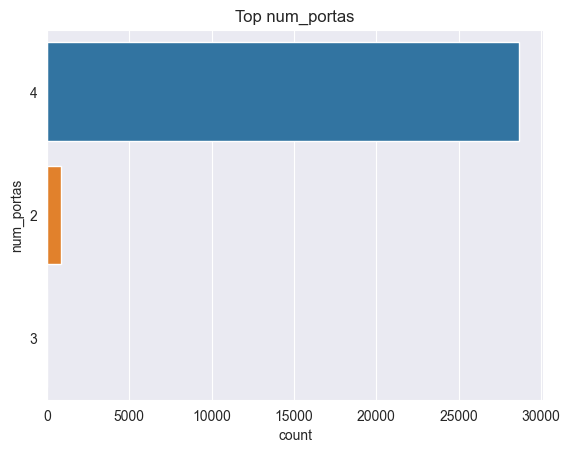

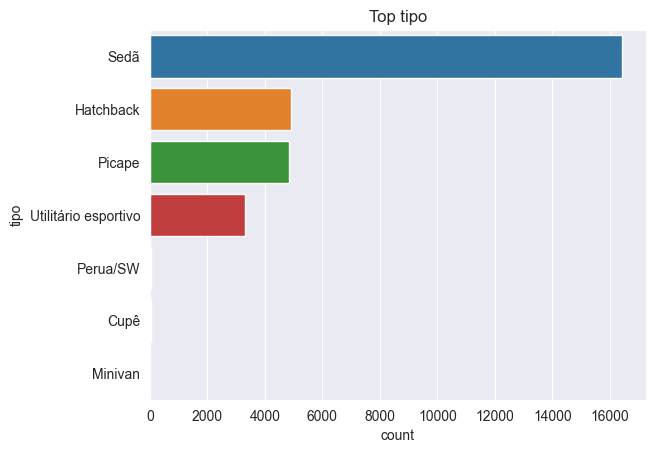

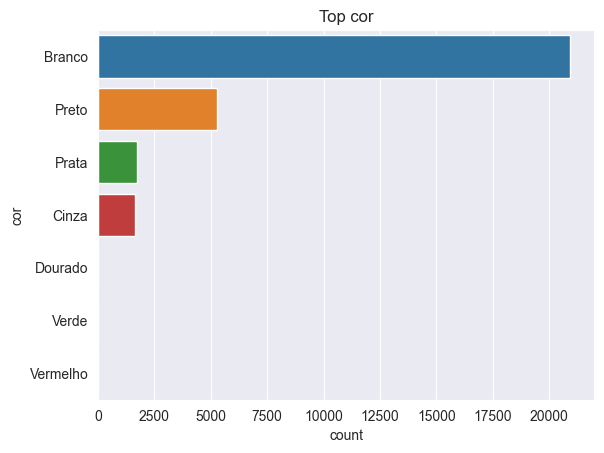

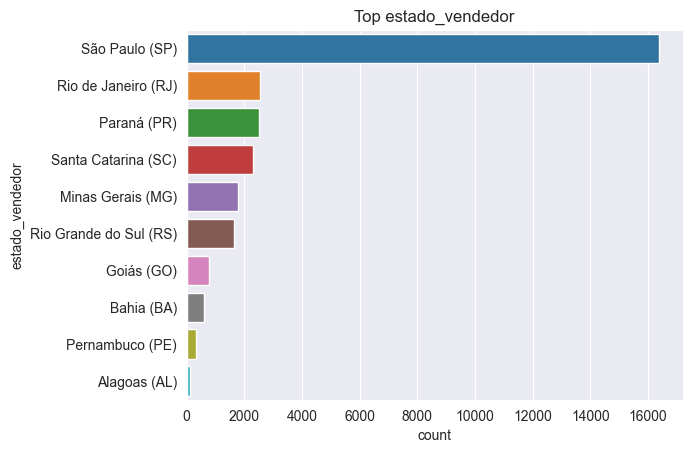

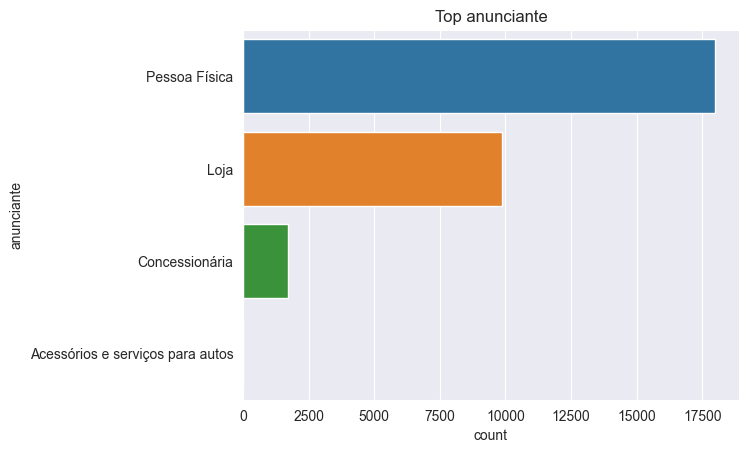

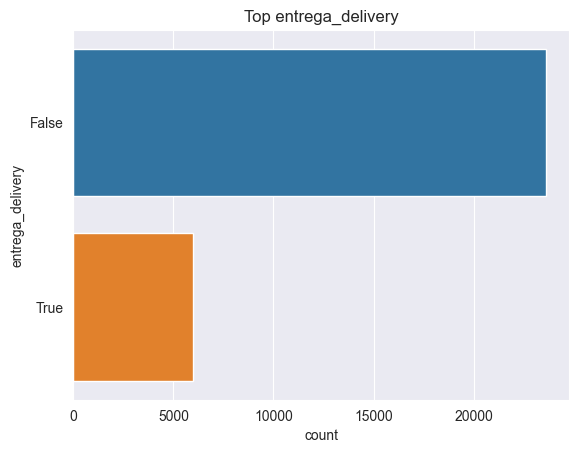

In [19]:
for feature in ["marca", "ano_de_fabricacao", "modelo", "cambio", "num_portas", "tipo", "cor", "estado_vendedor", "anunciante", "entrega_delivery"]:
    ax = sns.countplot(data=features, y=feature, order=features[feature].value_counts().head(10).index)
    ax.set_title("Top " + feature)
    plt.show()

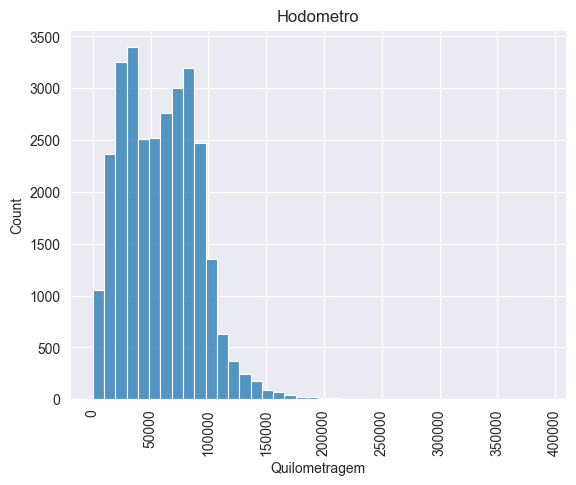

In [20]:
ax = sns.histplot(data=features, x="hodometro", bins=40)
ax.set_title("Hodometro")
ax.set_xlabel("Quilometragem")
plt.xticks(rotation=90)
plt.show()

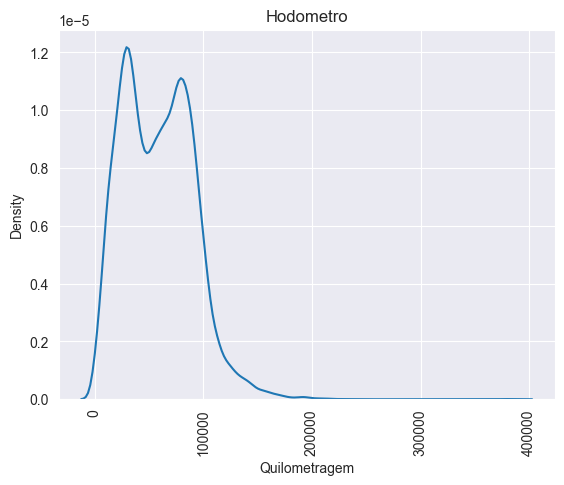

In [21]:
ax = sns.kdeplot(data=features, x="hodometro")
ax.set_title("Hodometro")
ax.set_xlabel("Quilometragem")
plt.xticks(rotation=90)
plt.show()

Analisando as correlações de Pearson para as colunas numéricas

<Axes: >

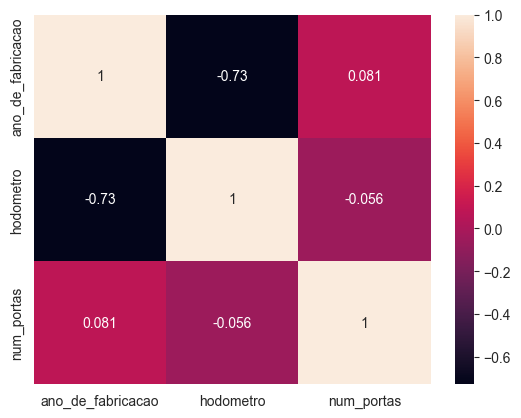

In [22]:
sns.heatmap(features[["ano_de_fabricacao","hodometro","num_portas"]].corr(), annot= True)

# 5. Feature engineering
---

In [23]:
features.head()

,id,marca,modelo,versao,ano_de_fabricacao,ano_modelo,hodometro,cambio,num_portas,tipo,blindado,cor,tipo_vendedor,cidade_vendedor,estado_vendedor,anunciante,entrega_delivery,troca,elegivel_revisao
0,300716223898539419613863097469899222392,NISSAN,KICKS,1.6 16V FLEXSTART SL 4P XTRONIC,2017,2017.0,67772.0,CVT,4,Sedã,N,Branco,PF,Rio de Janeiro,São Paulo (SP),Pessoa Física,False,False,False
1,279639842134129588306469566150288644214,JEEP,COMPASS,2.0 16V FLEX LIMITED AUTOMÁTICO,2017,2017.0,62979.0,Automática,4,Sedã,N,Branco,PF,Belo Horizonte,Minas Gerais (MG),Pessoa Física,False,False,False
2,56414460810621048900295678236538171981,KIA,SORENTO,2.4 16V GASOLINA EX 7L AWD AUTOMÁTICO,2018,2019.0,44070.0,Automática,4,Sedã,N,Preto,PJ,Santos,São Paulo (SP),Loja,True,False,False
3,56862509826849933428086372390159405545,VOLKSWAGEN,AMAROK,2.0 HIGHLINE 4X4 CD 16V TURBO INTERCOOLER DIES...,2013,2015.0,85357.0,Automática,4,Picape,N,Branco,PJ,Sorocaba,São Paulo (SP),Loja,True,True,False
4,338980975753200343894519909855598027197,SSANGYONG,KORANDO,2.0 GLS 4X4 16V TURBO DIESEL 4P AUTOMÁTICO,2013,2015.0,71491.0,Automática,4,Utilitário esportivo,N,Preto,PF,Rio de Janeiro,Rio de Janeiro (RJ),Pessoa Física,False,False,False


### We noticed that utilizing the variable age is considerably preferable to using the year of production; as a result, the values of the variable age are usually inside the age interval utilized in model training. This is not the case with the year_production; in our situation, the `ano_de_fabricacao` is limited to 2023, and as time passes, the year of production will get values exceeding 2023, causing these values to go outside of the training interval. As a result, we will add a variable called `idade` and remove the variable called `ano_de_fabricacao`

In [24]:
features["idade"] = 2023 - features["ano_de_fabricacao"]
features.head()

,id,marca,modelo,versao,ano_de_fabricacao,ano_modelo,hodometro,cambio,num_portas,tipo,blindado,cor,tipo_vendedor,cidade_vendedor,estado_vendedor,anunciante,entrega_delivery,troca,elegivel_revisao,idade
0,300716223898539419613863097469899222392,NISSAN,KICKS,1.6 16V FLEXSTART SL 4P XTRONIC,2017,2017.0,67772.0,CVT,4,Sedã,N,Branco,PF,Rio de Janeiro,São Paulo (SP),Pessoa Física,False,False,False,6
1,279639842134129588306469566150288644214,JEEP,COMPASS,2.0 16V FLEX LIMITED AUTOMÁTICO,2017,2017.0,62979.0,Automática,4,Sedã,N,Branco,PF,Belo Horizonte,Minas Gerais (MG),Pessoa Física,False,False,False,6
2,56414460810621048900295678236538171981,KIA,SORENTO,2.4 16V GASOLINA EX 7L AWD AUTOMÁTICO,2018,2019.0,44070.0,Automática,4,Sedã,N,Preto,PJ,Santos,São Paulo (SP),Loja,True,False,False,5
3,56862509826849933428086372390159405545,VOLKSWAGEN,AMAROK,2.0 HIGHLINE 4X4 CD 16V TURBO INTERCOOLER DIES...,2013,2015.0,85357.0,Automática,4,Picape,N,Branco,PJ,Sorocaba,São Paulo (SP),Loja,True,True,False,10
4,338980975753200343894519909855598027197,SSANGYONG,KORANDO,2.0 GLS 4X4 16V TURBO DIESEL 4P AUTOMÁTICO,2013,2015.0,71491.0,Automática,4,Utilitário esportivo,N,Preto,PF,Rio de Janeiro,Rio de Janeiro (RJ),Pessoa Física,False,False,False,10


In [49]:
data_test["idade"] = 2023 - data_test["ano_de_fabricacao"]
data_test.head()

,id,marca,modelo,versao,ano_de_fabricacao,ano_modelo,hodometro,cambio,num_portas,tipo,blindado,cor,tipo_vendedor,cidade_vendedor,estado_vendedor,anunciante,entrega_delivery,troca,elegivel_revisao,idade
0,13518783164498355150900635905895481162,NISSAN,VERSA,1.6 16V FLEXSTART V-DRIVE MANUAL,2021,2021.0,20258.0,Manual,4,Hatchback,N,Branco,PF,Rio de Janeiro,São Paulo (SP),Pessoa Física,False,False,False,2
1,299896161723793383246777788797566040330,FIAT,STRADA,1.4 MPI WORKING CS 8V FLEX 2P MANUAL,2021,2021.0,53045.0,Manual,2,Picape,N,Branco,PJ,Palmas,Amazonas (AM),Loja,False,False,False,2
2,316180649972302128246133616457018378621,AUDI,Q5,2.0 TFSI GASOLINA BLACK S TRONIC,2018,2019.0,32486.0,Automática,4,Utilitário esportivo,N,Branco,PF,Goiânia,Goiás (GO),Pessoa Física,False,False,False,5
3,222527157104148385909188217274642813298,CHEVROLET,CRUZE,1.4 TURBO LT 16V FLEX 4P AUTOMÁTICO,2019,2020.0,24937.0,Automática,4,Sedã,N,Cinza,PJ,Presidente Prudente,São Paulo (SP),Loja,False,False,False,4
4,160460343059850745858546502614838368036,FORD,ECOSPORT,1.5 TI-VCT FLEX SE AUTOMÁTICO,2019,2019.0,62074.0,Automática,4,Sedã,N,Branco,PJ,Limeira,São Paulo (SP),Loja,False,False,False,4


In [25]:
features.drop(columns=["ano_de_fabricacao"], inplace=True)
features.head()

,id,marca,modelo,versao,ano_modelo,hodometro,cambio,num_portas,tipo,blindado,cor,tipo_vendedor,cidade_vendedor,estado_vendedor,anunciante,entrega_delivery,troca,elegivel_revisao,idade
0,300716223898539419613863097469899222392,NISSAN,KICKS,1.6 16V FLEXSTART SL 4P XTRONIC,2017.0,67772.0,CVT,4,Sedã,N,Branco,PF,Rio de Janeiro,São Paulo (SP),Pessoa Física,False,False,False,6
1,279639842134129588306469566150288644214,JEEP,COMPASS,2.0 16V FLEX LIMITED AUTOMÁTICO,2017.0,62979.0,Automática,4,Sedã,N,Branco,PF,Belo Horizonte,Minas Gerais (MG),Pessoa Física,False,False,False,6
2,56414460810621048900295678236538171981,KIA,SORENTO,2.4 16V GASOLINA EX 7L AWD AUTOMÁTICO,2019.0,44070.0,Automática,4,Sedã,N,Preto,PJ,Santos,São Paulo (SP),Loja,True,False,False,5
3,56862509826849933428086372390159405545,VOLKSWAGEN,AMAROK,2.0 HIGHLINE 4X4 CD 16V TURBO INTERCOOLER DIES...,2015.0,85357.0,Automática,4,Picape,N,Branco,PJ,Sorocaba,São Paulo (SP),Loja,True,True,False,10
4,338980975753200343894519909855598027197,SSANGYONG,KORANDO,2.0 GLS 4X4 16V TURBO DIESEL 4P AUTOMÁTICO,2015.0,71491.0,Automática,4,Utilitário esportivo,N,Preto,PF,Rio de Janeiro,Rio de Janeiro (RJ),Pessoa Física,False,False,False,10


In [50]:
data_test.drop(columns=["ano_de_fabricacao"], inplace=True)
data_test.head()

,id,marca,modelo,versao,ano_modelo,hodometro,cambio,num_portas,tipo,blindado,cor,tipo_vendedor,cidade_vendedor,estado_vendedor,anunciante,entrega_delivery,troca,elegivel_revisao,idade
0,13518783164498355150900635905895481162,NISSAN,VERSA,1.6 16V FLEXSTART V-DRIVE MANUAL,2021.0,20258.0,Manual,4,Hatchback,N,Branco,PF,Rio de Janeiro,São Paulo (SP),Pessoa Física,False,False,False,2
1,299896161723793383246777788797566040330,FIAT,STRADA,1.4 MPI WORKING CS 8V FLEX 2P MANUAL,2021.0,53045.0,Manual,2,Picape,N,Branco,PJ,Palmas,Amazonas (AM),Loja,False,False,False,2
2,316180649972302128246133616457018378621,AUDI,Q5,2.0 TFSI GASOLINA BLACK S TRONIC,2019.0,32486.0,Automática,4,Utilitário esportivo,N,Branco,PF,Goiânia,Goiás (GO),Pessoa Física,False,False,False,5
3,222527157104148385909188217274642813298,CHEVROLET,CRUZE,1.4 TURBO LT 16V FLEX 4P AUTOMÁTICO,2020.0,24937.0,Automática,4,Sedã,N,Cinza,PJ,Presidente Prudente,São Paulo (SP),Loja,False,False,False,4
4,160460343059850745858546502614838368036,FORD,ECOSPORT,1.5 TI-VCT FLEX SE AUTOMÁTICO,2019.0,62074.0,Automática,4,Sedã,N,Branco,PJ,Limeira,São Paulo (SP),Loja,False,False,False,4


### We have 457 different car model's

In [26]:
features["modelo"].nunique()

457

### Every year, new models are introduced, thus any model that is not in the training models will cause problems during prediction. One alternative way would be to construct a generic class in which any unknown model would be configured. The feature will be removed, however new techniques will be tested in the future.

In [27]:
#features.drop(columns=["modelo","versao"], inplace=True)
#features.head()

# 6. Feature selection
---

In [28]:
from sklearn.model_selection import train_test_split

# Dividir os conjuntos de dados em treino e teste (80% treino, 20% teste)
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=314)

# Verificar os tamanhos dos conjuntos de treino e teste
print("Tamanho de X_train:", X_train.shape)
print("Tamanho de X_test:", X_test.shape)
print("Tamanho de y_train:", y_train.shape)
print("Tamanho de y_test:", y_test.shape)


Tamanho de X_train: (23667, 19)
Tamanho de X_test: (5917, 19)
Tamanho de y_train: (23667,)
Tamanho de y_test: (5917,)


In [29]:
drop_constants = DropConstantFeatures(tol=0.998)

In [30]:
correlated_sel = SmartCorrelatedSelection(threshold = 0.8)

In [31]:
recursive_elim = RecursiveFeatureElimination(RandomForestRegressor(), scoring = 'roc_auc', cv = 5)

In [32]:
X_train = drop_constants.fit_transform(X_train)
X_test = drop_constants.transform(X_test)

X_train = correlated_sel.fit_transform(X_train)
X_test = correlated_sel.transform(X_test)

X_train = recursive_elim.fit_transform(X_train,y_train)
X_test = recursive_elim.transform(X_test)

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
           ^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 367, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: continuous format is not supported

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.f

In [33]:
var_cat = X_train.select_dtypes('object').columns.tolist()

var_num = X_train.select_dtypes(exclude='object').columns.tolist()

var_all = X_train.columns.tolist()

In [35]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from category_encoders import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from catboost import CatBoostRegressor 


# Definir as pipelines
cat_pipe = Pipeline([('encoder', OneHotEncoder()), ('imputer', SimpleImputer(strategy='most_frequent'))])

num_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('imputer', SimpleImputer(strategy='median'))
])

# Definir a transformação de coluna
preproc = ColumnTransformer([('categoricos', cat_pipe, var_cat),
                             ('numericos', num_pipe, var_num)])

modelos = [
    KNeighborsRegressor(),
    RandomForestRegressor(),
    GradientBoostingRegressor(),
    CatBoostRegressor()
]

for modelo in modelos:
    model_pipeline = Pipeline(steps=[("preprocessor", preproc), ("modelo", modelo)])
    model_pipeline.fit(X_train, y_train)
    score = model_pipeline.score(X_test, y_test)
    print(modelo)
    print("model score: %.2f" % score)


KNeighborsRegressor()
model score: 0.677
RandomForestRegressor()
model score: 0.714
GradientBoostingRegressor()
model score: 0.612
Learning rate set to 0.067499
0:	learn: 79825.6052473	total: 81.9ms	remaining: 1m 21s
1:	learn: 77686.5744675	total: 101ms	remaining: 50.6s
2:	learn: 75819.3068517	total: 120ms	remaining: 39.9s
3:	learn: 74062.5552061	total: 140ms	remaining: 34.9s
4:	learn: 72484.3729370	total: 161ms	remaining: 32.1s
5:	learn: 71096.3168277	total: 182ms	remaining: 30.2s
6:	learn: 69855.1576695	total: 201ms	remaining: 28.5s
7:	learn: 68709.4030161	total: 219ms	remaining: 27.2s
8:	learn: 67586.3381384	total: 237ms	remaining: 26.1s
9:	learn: 66651.7724395	total: 257ms	remaining: 25.4s
10:	learn: 65770.7620130	total: 275ms	remaining: 24.7s
11:	learn: 64989.6613610	total: 293ms	remaining: 24.2s
12:	learn: 64285.6319780	total: 312ms	remaining: 23.7s
13:	learn: 63628.2310496	total: 331ms	remaining: 23.3s
14:	learn: 63063.9075806	total: 349ms	remaining: 22.9s
15:	learn: 62466.13519

* KNeighborsRegressor  - score: 0.677
* RandomForestRegressor - score: 0.714 
* GradientBoostingRegressor - score: 0.612
* CatBoostRegressor - score: 0.697



## Random Forest has the best performance, so this is the model to test.


In [51]:
data_test.head()

,id,marca,modelo,versao,ano_modelo,hodometro,cambio,num_portas,tipo,blindado,cor,tipo_vendedor,cidade_vendedor,estado_vendedor,anunciante,entrega_delivery,troca,elegivel_revisao,idade
0,13518783164498355150900635905895481162,NISSAN,VERSA,1.6 16V FLEXSTART V-DRIVE MANUAL,2021.0,20258.0,Manual,4,Hatchback,N,Branco,PF,Rio de Janeiro,São Paulo (SP),Pessoa Física,False,False,False,2
1,299896161723793383246777788797566040330,FIAT,STRADA,1.4 MPI WORKING CS 8V FLEX 2P MANUAL,2021.0,53045.0,Manual,2,Picape,N,Branco,PJ,Palmas,Amazonas (AM),Loja,False,False,False,2
2,316180649972302128246133616457018378621,AUDI,Q5,2.0 TFSI GASOLINA BLACK S TRONIC,2019.0,32486.0,Automática,4,Utilitário esportivo,N,Branco,PF,Goiânia,Goiás (GO),Pessoa Física,False,False,False,5
3,222527157104148385909188217274642813298,CHEVROLET,CRUZE,1.4 TURBO LT 16V FLEX 4P AUTOMÁTICO,2020.0,24937.0,Automática,4,Sedã,N,Cinza,PJ,Presidente Prudente,São Paulo (SP),Loja,False,False,False,4
4,160460343059850745858546502614838368036,FORD,ECOSPORT,1.5 TI-VCT FLEX SE AUTOMÁTICO,2019.0,62074.0,Automática,4,Sedã,N,Branco,PJ,Limeira,São Paulo (SP),Loja,False,False,False,4


In [53]:
predictions = model_pipeline.predict(data_test)

In [54]:
predictions_df = pd.DataFrame(predictions, columns=["preco"])
predictions_df.head()

,preco
0,74360.515331
1,78860.561477
2,230559.243086
3,120337.769868
4,105915.422439


In [57]:
result_df = pd.concat([data_test["id"], predictions_df], axis=1)
result_df.head()

,id,preco
0,13518783164498355150900635905895481162,74360.515331
1,299896161723793383246777788797566040330,78860.561477
2,316180649972302128246133616457018378621,230559.243086
3,222527157104148385909188217274642813298,120337.769868
4,160460343059850745858546502614838368036,105915.422439


In [58]:
result_df.to_csv("result.csv", index=False)